In [1]:
import torch
import numpy as np

In [2]:
from torch import nn, optim as opts
from plasma.training import Trainer, metrics, callbacks, data
from plasma.modules import *
from tensorflow.keras.datasets import mnist

In [3]:
(x, y), _ = mnist.load_data()

x = x[y < 3] / 127.5 - 1
y = y[y < 3]

class Data(data.StandardDataset):
    
    def get_len(self):
        return x.shape[0]
    
    def get_item(self, idx):
        return x[None, idx], y[idx]

In [4]:
model = nn.Sequential(*[
    PrimaryGroupConv2d(1, 16, kernel_size=3, padding=1),
    GroupBatchNorm2d(16),
    nn.ReLU(inplace=True),
    
    GroupConv2d(16, 32, kernel_size=3, padding=1),
    GroupBatchNorm2d(32),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(2, 2),
    
    
    GroupConv2d(32, 32, kernel_size=3, padding=1),
    GroupBatchNorm2d(32),
    nn.ReLU(inplace=True),
    
    GroupConv2d(32, 64, kernel_size=3, padding=1),
    GroupBatchNorm2d(64),
    nn.ReLU(inplace=True),
    
    nn.MaxPool2d(2, 2),
    
    
    GroupConv2d(64, 64, kernel_size=3, padding=1),
    GroupBatchNorm2d(64),
    nn.ReLU(inplace=True),
    
    GroupConv2d(64, 64, kernel_size=3, padding=1),
    GroupBatchNorm2d(64),
    nn.ReLU(inplace=True),
    
    Reshape(64, -1, 7, 7),
    GlobalAverage(rank=3),
    nn.Linear(64, 3),
    #nn.Softmax(dim=-1)
])

model.cuda(0)

Sequential(
  (0): PrimaryGroupConv2d(in_channels=1, out_channels=16, kernel=3, stride=1, padding=1, bias=True)
  (1): GroupBatchNorm2d(
    (norm): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (2): ReLU(inplace=True)
  (3): GroupConv2d(in_channels=16, out_channels=32, kernel=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
  (4): GroupBatchNorm2d(
    (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): GroupConv2d(in_channels=32, out_channels=32, kernel=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
  (8): GroupBatchNorm2d(
    (norm): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (9): ReLU(inplace=True)
  (10): GroupConv2d(in_channels=32, out_channels=64, kernel=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
  (11): GroupBat

In [5]:
loss = nn.CrossEntropyLoss()

In [6]:
#opt = opts.RMSprop(model.parameters())
opt = opts.SGD(model.parameters(), lr=0.25, momentum=0.9, nesterov=True)
trainer = Trainer(model, opt, loss, metrics=[metrics.accuracy])

In [7]:
cbs = [
    #callbacks.LrFinder(min_lr=1e-5, max_lr=12, epochs=3)
    callbacks.WarmRestart(1e-5, 10, factor=2, periods=3, snapshot=False),
    #callbacks.CLR(1e-5, 4),
    #callbacks.TrainingScheduler(epochs=1)
]

In [8]:
trainer.fit(Data(), callbacks=cbs, batch_size=64)

epoch 1



epoch 2


KeyboardInterrupt: 

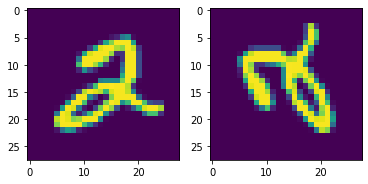

((1, 28, 28), 1.0, -1.0)

In [10]:
import matplotlib.pyplot as plt
import numpy as np

a = Data()[2][0]
ar = np.rot90(a, axes=[1, 2])
ar = np.copy(ar)

_, ax = plt.subplots(ncols=2)
ax[0].imshow(a[0])
ax[1].imshow(ar[0])
plt.show()
a.shape, a.max(), a.min()

In [11]:
img = torch.tensor(a[None], dtype=torch.float, device="cuda:0")
model.eval()(img)

tensor([[-4.6399, -8.7847, 13.8157]], device='cuda:0', grad_fn=<AddmmBackward>)

In [12]:
img = torch.tensor(ar[None], dtype=torch.float, device="cuda:0")
model.eval()(img)

tensor([[ -3.3610, -10.4309,  14.1333]], device='cuda:0',
       grad_fn=<AddmmBackward>)

(0.9843137254901961, -1.0)

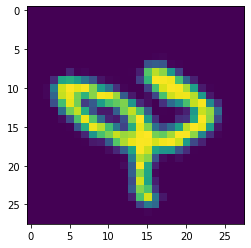

In [21]:
from albumentations import Rotate

r = Rotate(limit=(-60, -60), border_mode=1, p=1)
ar30 = r(image=a[0])["image"]

plt.imshow(ar30)
ar30.max(), ar30.min()

In [22]:
img = torch.tensor(ar30[None, None], dtype=torch.float, device="cuda:0")
model.eval()(img)

tensor([[ -3.6898, -11.8930,  16.0784]], device='cuda:0',
       grad_fn=<AddmmBackward>)